# Nifty 50 Partial Replication 
Index funds have become a household occurence in the financial sphere, especially for retail investors, due to their simplicity, diversification and low cost compared to actively managed funds. Following an index can be done in one of two ways:
- **Full replication:** The most common approach, where a fund holds all constituent stocks present in the index, with the same weights as the index.
- **Partial Replication:** With this approach, only a subset of the index's constituents is selected, which should aim to approximate the overall index performance.

Partial replication can offer a number of benefits over full replication, but mainly:
- Lower transaction costs: Reducing the number of stocks traded minimizes fees such as brokerage fees.
- Reduced Trading fees: By potentially avoiding low-liquidity stocks, we avoid have wider bid-ask spreads, as well as having less market impact.
- Higher flexibility: Funds can add other constraints on top of avoiding low-liquidity stocks, such as those on sectors or specific stocks, giving them better control over their risk management.
Our project's goal is to apply supervised learning techniques to develop a partial replication strategy, minimizing the tracking error of our portfolio.

## Methodology
The project will focus on the NIFTY 100 index, which includes the top 100 companies in the National Stock Exchange of India (NSE) based on market capitalization. 

We will begin by gathering the minute-level data for both the index as well as the constituents data. Combining the data into a single dataframe, and perform some basic cleaning tasks, removing certain columns with a large number of empty values, as well as rows without target value, etc. Our target variable will be the **NIFTY 100 index price**.

Since our goal is to reduce the number of constituents to use only a subset of the total 100 stocks, our models will follow a 2 step approach:
1. Feature Selection: We will first apply different feature selection techniques, (Lasso regression, Correlation matrix, Mutual information) to identify the most relevant stocks for our model.
2. Model Training: Once the most relevant features (stocks) are selected, we will train different supervised learning models on the reduced dataset, these models will predict the weights for each of the relevant stocks.
To ensure the robustness of the test results, while accounting for the nature of the data (ordered time series) we will use a **sliding window approach**, where:
* A fixed-size window (roughly 1-year) is used to train the model.
* The model will be tested on roughly the next 3 months.
* The window will slide forward, repeating until we use all available data.

For a certain model, the overall out-of-sample error will be the average error over all the windows. The error we will aim to minimize is the **tracking error**, for simplicity models will minimize MSE. Finally, we will compare models by plotting the error vs the number of stocks, to visualize how it evolves as we reduce the size of the subset of constituents chosen.



In [1]:
from sklearn.linear_model import Lasso, ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, ParameterGrid
import matplotlib.pyplot as plt
import os
import glob
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")
warnings.filterwarnings("always", category=ConvergenceWarning)
import seaborn as sns
from sklearn.feature_selection import SelectFromModel,mutual_info_regression
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers
from tensorflow import keras
import tensorflow as tf
import lightgbm as lgb
from sklearn.svm import SVR

## Tracking Error
Tracking error is the metric most commonly used to judge how well a replicating portfolio tracks the benchmark index, for full replication we would expect this to be close to 0 (slightly higher than 0 due to transaction costs or rebalancing delays).

The tracking error is defined as the standard deviation of the differences between the index and replicating portfolio over a specified time period. Central to this metric is the time period that the difference in returns is calculated over, usually this is done daily, weekly or monthly.

$$
\text{Tracking Error} = \sqrt{\frac{\sum_{t=1}^T \left( R_{portfolio}(t) - R_{index}(t) \right)^2}{T}}
$$

Where: 
*  $R_{portfolio}(t)$ is the portfolio return at time $t$,  
*  $R_{index}(t)$ is the index's return at time $t$,  
*  $T$  is the total number of time periods.

We base ourselves on this metric, and add a small adjustment, where from the first return of the portfolio, the trading cost is subtracted, this is a simulated trading cost, which we will simply set to 0.2%.

In the next sections we will see that our data comes in minute intervals, so, to obtain the tracking error for daily returns, we will first aggregate the returns per day, and then utilize the formula above. To aggregate returns we do:

$$
R_{\text{daily}} = \left( \prod_{j=1}^{m} (1 + R_{\text{minute},j}) \right) - 1
$$

Where:

* $R_{\text{daily}}$ is the aggregated daily return
* $R_{\text{minute},j}$ is the minute level return
* m: is the number of minute level returns we have per day

In [2]:
def tracking_error(y_true, y_pred):
    y_true = pd.DataFrame(y_true)
    y_true.columns = ['target'] 
    data = y_true.copy()
    data['predicted'] = y_pred
    diff = data['target'] - data['predicted']
    return np.std(diff)

# Data
The data for this project will be taken from 2 Kaggle datasets:

* [Nifty 100 Constituents](https://www.kaggle.com/datasets/debashis74017/stock-market-data-nifty-50-stocks-1-min-data): This data set will be used to gather price data for all constituents for the NIFTY 100 index. The dataset contains a file per stock, which contains OHLC (Open, High, Low, Close) as well as Volume data.
* [Nifty 100 Index Data](https://www.kaggle.com/datasets/debashis74017/nifty-50-minute-data): This data set will be used to get the price data for the NIFTY 100 index price.

In order to speed up the execution, an intermediate dataset is created where we keep only closing prices for all stocks, in one single file. This dataset is [Nifty 100 Closing Only Data](https://www.kaggle.com/datasets/danielbrito99/nifty-50-closing-data). The script used to extract this intermediate data, is described in the cell below.

As was mentioned before our target variable will be the **NIFTY 100 Index Price**, by training the model with a reduced number of constituents to predict the index price based on that reduced subset, we will obtain weights for each of them. During the testing phase, we will use these weights to evaluate the model's performance and verify how well the selected subset mimics the index price. 

directory_path = '/kaggle/input/stock-market-data-nifty-50-stocks-1-min-data'
pattern = os.path.join(directory_path, "*.csv")  # Change "*.csv" to match other patterns if needed
Get the list of files that match the pattern
file_list = glob.glob(pattern)

def fetch_data(cols, file_list):
    df_list = []
    for file in tqdm(file_list):
        stock_name = os.path.basename(file).split("_")[0]
        file_df = pd.read_csv(file, index_col=0)
        file_df = file_df[[cols]]
        file_df.columns = pd.MultiIndex.from_product([[stock_name], file_df.columns])
        df_list.append(file_df)
    return pd.concat(df_list, axis=1)

df = fetch_data('close')
df.to_csv('/kaggle/input/nifty_50_closing.csv')

In [3]:
df = pd.read_csv('/kaggle/input/nifty-50-closing-data/nifty_50_closing.csv', index_col=0, header=[0, 1])
df = df.xs('close', level=1, axis=1)
df.index = pd.to_datetime(df.index)
nan_rows = df.isna().any(axis=1)

num_nan_rows = nan_rows.sum()
print(f"Number of rows with NaN values: {num_nan_rows}")

nifty_100_closing = pd.read_csv('/kaggle/input/nifty-50-minute-data/NIFTY 100_minute.csv', index_col=0)[['close']]
nifty_100_closing.index = pd.to_datetime(nifty_100_closing.index)
nifty_100_closing.rename(columns={'close': 'NIFTY_100'}, inplace=True)

Number of rows with NaN values: 639555


## Data Cleaning
Our data cleaning will be simple, we will focus on remediating the high number of NaN's present in the dataset.
Most importantly, we will focus on sequences of NaN values, which are problematic for our problem, as conventional techniques such as forward fill or interpolation become less effective the longer the period of missing data. Conversely, sparse or isolated NaNs are less of an issue, as they can be effectively substituted using these techniques with minimal loss of information. 


With this in mind, we perform the following steps:

* Remove NIFTY 50 and NIFTY BANK stocks, as they represent indices, not stocks.
* To get rid of periods where a large number of stocks all are missing data, we remove the rows with higher than 25 NaNs.
* Inspecting the longest NaN period for each column, we will get rid of those columns where the value is large:
    * HDFCAMC
    * ICICIPRULI
    * HDFCLIFE
    * GLAND
    * ADANIGREEN
    * DMART
    * ICICIGI
    * BANDHANBNK
    * INDIGO
    * SBILIFE
    * LICI
    * SBICARD
    * LTI
*  At this point the number of NaN rows and consecutive NaNs is much lower, so we can use forward fill to populate them with the last know values.

Finally, we resample the data to a daily frequency, retaining the last value of each day. This process helps smooth out short-term fluctuations and noise that can occur in intraday market movements, providing a clearer view of the broader trends and reducing the impact of high-frequency volatility.

In [4]:
def longest_nan_period(series):
    max_nan_period = 0
    current_nan_period = 0
    for value in series:
        if pd.isna(value):
            current_nan_period += 1
            max_nan_period = max(max_nan_period, current_nan_period)
        else:
            current_nan_period = 0
    return max_nan_period

In [5]:
# Remove Nifty 50 and Nifty Bank as they aren't stocks but indices
df.drop(columns=['NIFTY 50', 'NIFTY BANK'], inplace=True)

# Removing rows with more than 25 stocks without data
nan_counts = df.isna().sum(axis=1)
df = df[nan_counts <= 25]

In [6]:
# Now we observe per column, the longest period with NaN values
longest_nan_periods = {column: longest_nan_period(df[column]) for column in df.columns}

# Print the longest NaN period for each column
for column, period in longest_nan_periods.items():
    print(f"Longest period of NaN values in column {column}: {period} periods")

Longest period of NaN values in column HDFCAMC: 305198 periods
Longest period of NaN values in column APOLLOHOSP: 1 periods
Longest period of NaN values in column BOSCHLTD: 3 periods
Longest period of NaN values in column INDUSTOWER: 1 periods
Longest period of NaN values in column BERGEPAINT: 1 periods
Longest period of NaN values in column MARICO: 0 periods
Longest period of NaN values in column ICICIPRULI: 144000 periods
Longest period of NaN values in column HDFCLIFE: 242175 periods
Longest period of NaN values in column SBIN: 0 periods
Longest period of NaN values in column SUNPHARMA: 0 periods
Longest period of NaN values in column COALINDIA: 0 periods
Longest period of NaN values in column WIPRO: 1 periods
Longest period of NaN values in column BAJAJ-AUTO: 1 periods
Longest period of NaN values in column GODREJCP: 1 periods
Longest period of NaN values in column UPL: 0 periods
Longest period of NaN values in column SIEMENS: 0 periods
Longest period of NaN values in column BPCL: 

In [7]:
# Drop columns with higher number of NaNs
df.drop(columns=['HDFCAMC', 'ICICIPRULI', 'HDFCLIFE', 'GLAND', 'ADANIGREEN', 'LTI', 'SBICARD',
                 'DMART','ICICIGI','BANDHANBNK','INDIGO','SBILIFE','LICI'], inplace=True)

# Drop rows that still have NaNs in place
df.dropna(inplace=True)

In [8]:
df.index = df.index.tz_localize(None)
df_total = df.join(nifty_100_closing, how='left')

In [9]:
df_total.dropna(inplace=True)
df_total.sort_index(inplace=True)

# Resample to Hourly Period
daily_df = df_total.resample('D').last()
daily_df.dropna(inplace=True)

daily_df = daily_df.replace(0, np.nan)  # Convert zeroes back to NaNs
daily_df = daily_df.pct_change().dropna()
daily_df = daily_df*100
daily_X = daily_df.drop(columns=['NIFTY_100'])
daily_y = daily_df['NIFTY_100']

# Models

Firstly, let's explain the general architecture of the model, firstly, we must understand the pitfalls of using time series data, and how it affects our choice of cross validation strategy. Since the order of data must be preserved, we cannot use a conventional cross validation, and rather opt for a TimeSeriesSplit, specifically, we set the training and test sizes of the window, to get the desired sliding window result, where the training window is roughly 1 year, and the testing widnow around 3 months, this yields a total of 18 windows.

Knowing this, we propose the following general architecture, for a given model and threshold:

For each fold:

1. Perform feature selection (ex: Lasso with high alpha, Dropping Correlated variables, Mutual Information) using the threshold.
2. Train model on reduced feature space, with hyperparameter tuning to choose best parameters.
3. Save the tracking error and number of features (stocks) used in training

Finally, we return the following averages over the folds
* Average number of stocks.
* Average tracking error.

We will observe how different models (LinearRegression, ElasticNet, LightGBMRegressor and SupportVectorRegressor) produce predictions and produce a plot for the average tracking error against the average number of stocks.

## Correlation - Lasso

In [10]:
def remove_correlated_features(X_train, threshold):
    X_train = pd.DataFrame(X_train)
    
    # Compute the correlation matrix (absolute values)
    corr_matrix = X_train.corr().abs()
    
    # Create a mask to select only the upper triangle of the correlation matrix
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features with correlation greater than the threshold
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    print(f"Features to drop (correlation > {threshold}): {to_drop}")
    selected_features = [i for i in range(X_train.shape[1]) if i not in to_drop]
    
    return selected_features
    

In [11]:
from sklearn.preprocessing import StandardScaler


def Corr_Lasso(threshold, X, y, debug=False):
    tscv = TimeSeriesSplit(n_splits=13, max_train_size=85000, test_size=45000)
    stocks = []
    num_stocks = []
    fold_scores = []

    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_train_cv)
        X_test_scaled = scaler.transform(X_test_cv)
        
        # Feature selection using correlation matrix
        selected_indices = remove_correlated_features(X_scaled, threshold)

        X_train_selected = X_scaled[:, selected_indices]
        X_test_selected = X_test_scaled[:, selected_indices]
        if debug == True:
            print(f"Selected {len(selected_indices)} stocks")
        num_stocks.append(len(selected_indices))
        stocks.append(selected_indices)

        best_alpha = None
        best_score = float('inf')  # Assuming lower is better for your metric
        for alph in [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.002, 0.0025]:
            lasso = Lasso(alpha=alph, max_iter=15000)
            lasso.fit(X_train_selected, y_train_cv)
            y_pred = lasso.predict(X_test_selected)
            fold_score = tracking_error(y_test_cv, y_pred)
            
            if fold_score < best_score:
                best_score = fold_score
                best_alpha = alph

        print(f"Best Alpha for this fold: {best_alpha}, Best Fold Score: {best_score}")
        fold_scores.append(best_score)

    # Calculate the average score across all folds
    average_score = np.mean(fold_scores)

    # Get average stocks chosen over all folds
    average_selected_features = np.mean(num_stocks)

    # Print the tracking error for this alpha
    print(f"Threshold: {threshold}, Tracking Error: {average_score}")
    return stocks, average_selected_features, average_score

In [12]:
def Corr_Lasso_plot(X,y):
    thresholds = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
    tracking_errors = []
    num_stocks_list = []
    
    for threshold in thresholds:
        print(f"----------Starting threshold: {threshold}-------------")
        _, num_stocks, tracking_err = Corr_Lasso(threshold, X, y, debug=False)
        num_stocks_list.append(num_stocks)
        tracking_errors.append(tracking_err)
    
    plt.set_xlabel('Alpha')
    plt.set_ylabel('Number of Stocks')    
    plt.plot(num_stocks_list, tracking_errors, marker='o', label='Number of Stocks')
    plt.title('Number of Stocks and Tracking Error vs. Alpha')    
    fig.tight_layout()
    plt.savefig('Corr-Lasso.png')
    plt.show()

## Lasso - ElasticNet



We will utilize a Lasso model with a high alpha value to perform feature selection, this will drop the coefficients for less important features to 0. After that we retrain a Lasso model with hyperparameter tuning.

In [13]:
from sklearn.preprocessing import StandardScaler

def Lasso_ElasticNet(alpha, X, y, params, debug=False):    
    tscv = TimeSeriesSplit(n_splits=5, max_train_size=700, test_size=100)
    stocks = []
    num_stocks = []
    fold_scores = []

    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
        train_period = X.iloc[train_index].index
        test_period = X.iloc[test_index].index

        # Convert to date format
        train_start_date, train_end_date = train_period.min(), train_period.max()
        test_start_date, test_end_date = test_period.min(), test_period.max()

        print(f"Train period: {train_start_date} to {train_end_date}")
        print(f"Test period: {test_start_date} to {test_end_date}")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_train_cv)
        X_test_scaled = scaler.transform(X_test_cv)
        
        # Feature selection with alpha from list
        lasso_fs = Lasso(alpha=alpha, max_iter=1000)
        lasso_fs.fit(X_scaled, y_train_cv)

        selector = SelectFromModel(lasso_fs, threshold=10e-10, max_features=None)
        X_selected_train = selector.transform(X_scaled)
        X_selected_test = selector.transform(X_test_scaled)

        selected_features = np.where(selector.get_support())[0] 
        print(f"Selected {len(selected_features)} stocks")
        num_stocks.append(len(selected_features))
        stocks.append(selected_features)

        best_alpha = None
        best_score = float('inf')
        for param in ParameterGrid(params):
            if debug == True:
                print(f"Trying combination {param}")
            model = ElasticNet(**param)
            model.fit(X_selected_train, y_train_cv)
            y_pred = model.predict(X_selected_test)

            train_fold_score = tracking_error(y_train_cv, model.predict(X_selected_train))
            fold_score = tracking_error(y_test_cv, y_pred)
            print(f"Train Error: {train_fold_score}, Test Error: {fold_score}")

            if fold_score < best_score:
                best_score = fold_score
                best_params = param
        print(f"Best Params for this fold: {best_params}, Best Test Score: {best_score}")

        #print(f"Best Alpha for this fold: {best_alpha}, Best Fold Score: {best_score}")
        fold_scores.append(best_score)

    # Calculate the average score across all folds
    average_score = np.mean(fold_scores)

    # Get average stocks chosen over all folds
    average_selected_features = np.mean(num_stocks)

    # Print the tracking error for this alpha
    print(f"Alpha: {alpha}, Number of Stocks: {average_selected_features}, Average Tracking Error (bps): {average_score}")
    return stocks, average_selected_features, average_score

In [14]:
def Lasso_ElasticNet_plot(X,y):
    alphas = np.logspace(-0.5, -2, 10)
    param_grid = {
        'alpha': [0.005, 0.0075, 0.01, 0.02, 0.025],
        'l1_ratio': [0.3, 0.5, 0.7]
    }
    tracking_errors = []
    num_stocks_list = []
    
    for alpha in alphas:
        print(f"----------Starting alpha {alpha}-------------")
        _, num_stocks, tracking_err = Lasso_ElasticNet(alpha, X, y, param_grid)
        num_stocks_list.append(num_stocks)
        tracking_errors.append(tracking_err)
    
    plt.xlabel('Alpha')
    plt.ylabel('Number of Stocks')    
    plt.plot(num_stocks_list, tracking_errors, marker='o', label='Number of Stocks')
    plt.title('Number of Stocks and Tracking Error vs. Alpha')    
    plt.grid(True)
    plt.savefig('Lasso-ElasticNet.png')
    plt.show()

### Mutual Info - Lasso

Using mutual information between variables, which measures the dependency between them, 0 value being independence. By getting the mutual information between the features (stocks) and the target (NIFTY 100) we can "discard" the variables with lower dependencies. After feature selection, we traing a Lasso model with CV.

In [15]:
from sklearn.preprocessing import StandardScaler


def MI_Experiment(percentile, X, y, model_class, params, debug=False):
    tscv = TimeSeriesSplit(n_splits=5, max_train_size=700, test_size=100)
    stocks = []
    num_stocks = []
    fold_scores = []

    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_train_cv)
        X_test_scaled = scaler.transform(X_test_cv)

        # Feature selection with alpha from list
        mi_scores = mutual_info_regression(X_train_cv, y_train_cv)
        mi_scores_series = pd.Series(mi_scores, index=X_train_cv.columns)

        threshold_value = mi_scores_series.quantile(percentile)        

        selected_features = mi_scores_series[mi_scores_series > threshold_value].index
        selected_indices = [X_train_cv.columns.get_loc(feature) for feature in selected_features]
        print(f"Selected Features: {selected_indices}")

        # Filter the NumPy arrays based on the selected feature indices
        X_train_selected = X_scaled[:, selected_indices]
        X_test_selected = X_test_scaled[:, selected_indices]        

        if debug == True:
            print(f"Selected {len(selected_features)} stocks")
        num_stocks.append(len(selected_features))
        stocks.append(selected_features)

        best_params = None
        best_score = float('inf')  # Assuming lower is better for your metric
        for param in ParameterGrid(params):
            if debug == True:
                print(f"Trying combination {param}")
            model = model_class(**param)
            model.fit(X_train_selected, y_train_cv)
            y_pred = model.predict(X_test_selected)

            train_fold_score = tracking_error(y_train_cv, model.predict(X_train_selected))
            fold_score = tracking_error(y_test_cv, y_pred)
            print(f"Train Error: {train_fold_score}, Test Error: {fold_score}")

            if fold_score < best_score:
                best_score = fold_score
                best_params = param
        print(f"Best Params for this fold: {best_params}, Best Test Score: {best_score}")
        fold_scores.append(best_score)

    # Calculate the average score across all folds
    average_score = np.mean(fold_scores)

    # Get average stocks chosen over all folds
    average_selected_features = np.mean(num_stocks)

    # Print the tracking error for this alpha
    print(f"Percentile: {percentile}, Tracking Error: {average_score}")
    return stocks, average_selected_features, average_score

In [16]:
def MI_Experiments_plot(X,y):
    tracking_errors = []
    num_stocks_list = []
    results_by_model = {}
    
    percentiles = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
    models = {
        'SVR': (SVR, {
            'C': [0.1, 1, 10],
            'epsilon': [0.01, 0.1, 0.5],
            'kernel': ['rbf', 'linear'],
        }),
        'ElasticNet': (ElasticNet, {
            'alpha': [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.002, 0.0025],
            'l1_ratio': [0.1, 0.5, 0.7, 0.9]
        }),
        'LightGBM': (lgb.LGBMRegressor, {
            'n_estimators': [300], 
            'learning_rate': [0.075, 0.1, 0.085],
            'colsample_bytree': [0.5, 0.7],
            'max_depth': [10],
            'n_jobs': [-1],
            'boosting_type': ['gbdt'],
            'verbose': [-1]
        })
    }
    
    for model_name, (model, param_grid) in models.items():
        tracking_errors = []
        num_stocks_list = []
        
        for percentile in percentiles:
            print(f"Starting percentile: {percentile} for model: {model_name}")
            _, num_stocks, tracking_err = MI_Experiment(percentile, X, y, model, param_grid)
            num_stocks_list.append(num_stocks)
            tracking_errors.append(tracking_err)
        
        # Plotting the results for each model on the same plot
        plt.plot(num_stocks_list, tracking_errors, marker='x', label=f'{model_name}')
    
    plt.xlabel('Number of Stocks')
    plt.ylabel('Tracking Error')
    plt.title('Mutual Information Tracking Error by Model')
    plt.grid(True)
    plt.legend()
    plt.savefig("MI-AllModels.png")
    plt.show()

----------Starting alpha 0.31622776601683794-------------
Train period: 2017-07-26 00:00:00 to 2020-08-17 00:00:00
Test period: 2020-08-18 00:00:00 to 2021-01-25 00:00:00
Selected 15 stocks
Train Error: 0.26944055023318825, Test Error: 0.34388592172752075
Train Error: 0.2694558770504546, Test Error: 0.3438749384922635
Train Error: 0.26947734012527935, Test Error: 0.3438649328512749
Train Error: 0.269461266222213, Test Error: 0.34403949728042027
Train Error: 0.2694958388139118, Test Error: 0.3440248209593662
Train Error: 0.2695440876424048, Test Error: 0.3440183856041872
Train Error: 0.269490104778485, Test Error: 0.34419566890020026
Train Error: 0.2695514725493823, Test Error: 0.34418372470719755
Train Error: 0.2696371557682404, Test Error: 0.34418630103047415
Train Error: 0.2696863009160686, Test Error: 0.3448406247070384
Train Error: 0.26993102486815174, Test Error: 0.3448798543125369
Train Error: 0.2702729755495013, Test Error: 0.3449748635319711
Train Error: 0.26983196842621326, Te

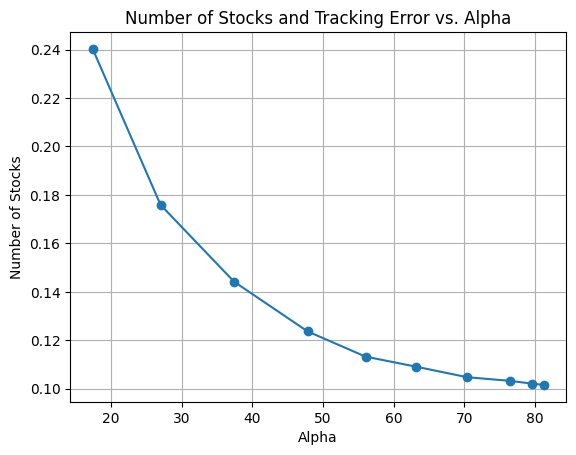

In [17]:
Lasso_ElasticNet_plot(daily_X,daily_y)

Starting percentile: 0.8 for model: SVR
Selected Features: [5, 17, 22, 30, 33, 38, 49, 51, 52, 53, 58, 68, 69, 70, 71, 72, 78]
Train Error: 1.027775211214275, Test Error: 0.5544481273256816
Train Error: 0.3200120087404795, Test Error: 0.3876907715270042
Train Error: 1.0300299712196743, Test Error: 0.5634766930768066
Train Error: 0.3160016666420685, Test Error: 0.38381394210974257
Train Error: 1.0491447635013191, Test Error: 0.6205531397665576
Train Error: 0.3157061083028215, Test Error: 0.3855803952541957
Train Error: 0.7913418871970755, Test Error: 0.3979430018267502
Train Error: 0.3194095079270949, Test Error: 0.3870598702551804
Train Error: 0.7924352332009864, Test Error: 0.39339361143902946
Train Error: 0.31585977476887944, Test Error: 0.3834807069928681
Train Error: 0.8168061989866224, Test Error: 0.41086177119492173
Train Error: 0.31575180154476873, Test Error: 0.38491789208470534
Train Error: 0.14148786037800315, Test Error: 0.43483828856939777
Train Error: 0.3195561942451758, T

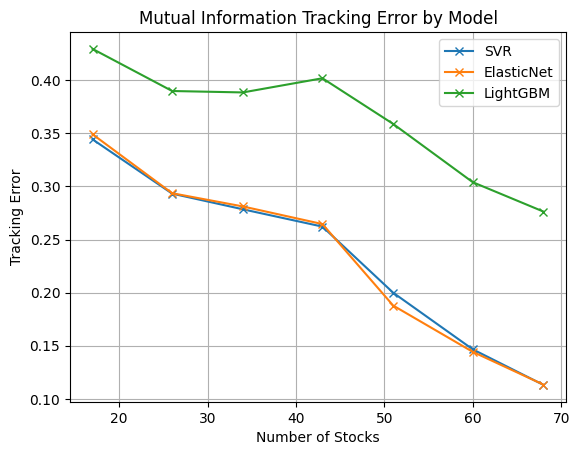

In [18]:
MI_Experiments_plot(daily_X,daily_y)

# Sparse Autoencoder - ElasticNet

In [19]:
from tensorflow.keras.callbacks import Callback


def autoencoder_feature_selection(X, input_dim, encoding_dim, K, sparsity_level, lambda_sparse, debug=False):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu', 
                    activity_regularizer=regularizers.l1(10e-2))(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    def sparse_loss(y_true, y_pred):
        mse_loss = tf.reduce_mean(keras.losses.MeanSquaredError()(y_true, y_pred))
        hidden_layer_output = encoder(y_true)
        mean_activation = tf.reduce_mean(hidden_layer_output, axis=0)
    
        kl_divergence = tf.reduce_sum(sparsity_level * tf.math.log(sparsity_level / (mean_activation + 1e-10)) +
                                      (1 - sparsity_level) * tf.math.log((1 - sparsity_level) / (1 - mean_activation + 1e-10)))
    
        return mse_loss + lambda_sparse * kl_divergence
    
    # Train autoencoder
    autoencoder.fit(X, X, epochs=200, batch_size=16, validation_split=0.1, verbose=0, shuffle=False)

    # Calculate baseline reconstruction error
    baseline_reconstruction = autoencoder.predict(X, verbose=0)
    baseline_error = np.mean(np.square(X - baseline_reconstruction), axis=0)
    
    importance_scores = []
    
    for i in range(input_dim):
        X_modified = X.copy()
        X_modified[:, i] = 0  # Zero out the i-th feature
        modified_reconstruction = autoencoder.predict(X_modified, verbose=0)
        modified_error = np.mean(np.square(X - modified_reconstruction), axis=0)
        information_loss = np.sum(modified_error - baseline_error)
        importance_scores.append((i, information_loss))
    
    # Rank features based on importance scores
    importance_scores.sort(key=lambda x: x[1], reverse=True)
    
    # Select top K features
    top_feature_indices = [index for index, _ in importance_scores[:K]]
    if debug:
        print(f"Selected Features: {top_feature_indices}")
    
    return top_feature_indices, encoder, autoencoder


In [20]:
def AE_Experiment(K, X, y, model_class, params, encoding_dim, sparsity_level, lambda_sparse, debug=False):
    tscv = TimeSeriesSplit(n_splits=5, max_train_size=700, test_size=100)
    fold_scores = []
    num_stocks_list = []

    for train_index, test_index in tscv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_train_cv)
        X_test_scaled = scaler.transform(X_test_cv)

        # Create and train Sparse Autoencoder
        input_dim = X_scaled.shape[1]
        features, autoencoder, encoder = autoencoder_feature_selection(X_scaled, input_dim, encoding_dim, K, sparsity_level, lambda_sparse, debug)
        
        # Set non-selected features to 0
        X_train_selected = X_scaled[:, features]
        X_test_selected = X_test_scaled[:, features]
    
        best_params = None
        best_score = float('inf')
        for param in ParameterGrid(params):
            if debug:
                print(f"Trying combination {param}")
            model = model_class(**param)
            model.fit(X_train_selected, y_train_cv)
            y_pred = model.predict(X_test_selected)

            # Update number of non zero weight stocks
            num_stocks = K - np.sum(np.abs(model.coef_) < 1e-5)
            
            train_fold_score = tracking_error(y_train_cv, model.predict(X_train_selected))
            fold_score = tracking_error(y_test_cv, y_pred)
            if debug:
                print(f"Train Error: {train_fold_score}, Test Error: {fold_score}, Coeffs 0? : {sum(abs(coef) < 10e-5 for coef in model.coef_)}")

            if fold_score < best_score:
                best_score = fold_score
                best_params = param
                best_num_stocks = num_stocks

        print(f"Best Params for this fold: {best_params}, Best Test Score: {best_score}")
        fold_scores.append(best_score)
        num_stocks_list.append(best_num_stocks)

    average_score = np.mean(fold_scores)
    average_num_stocks = np.mean(num_stocks_list)
    return average_score, average_num_stocks

In [21]:
def plot_AE_Lasso(X,y):
    
    num_stocks_thresh = [20, 25, 30, 35, 40, 50, 60, 70]
    param_grid = {
        'alpha': [0.005, 0.0075, 0.01, 0.02, 0.025],
        'l1_ratio': [0.4, 0.6]
    }
    AE_params = {
        'sparsity_level': [0.05, 0.1, 0.15],
        'lambda_sparse': [0.05, 0.1, 0.2]
    }
    encoding_dims = [3, 10]
    results_by_dim = {}

    for encoding_dim in encoding_dims:
        tracking_errors = []
        num_stocks_list = []
        
        for K in num_stocks_thresh:
            print(f"Starting portofolio with {K} stocks")
            best_params = {}
            lowest_tracking_err = float('inf')
            for sparsity_level in AE_params['sparsity_level']:
                for lambda_sparse in AE_params['lambda_sparse']:
                    # Call AE_Experiment with the current parameters
                    tracking_err, num_stocks = AE_Experiment(
                        K, X, y, ElasticNet, param_grid, encoding_dim, sparsity_level, lambda_sparse, debug=False
                    )
                    
                    if tracking_err < lowest_tracking_err:
                        lowest_tracking_err = tracking_err
                        best_params = {
                            'sparsity_level': sparsity_level,
                            'lambda_sparse': lambda_sparse
                        }
                        best_num_stocks = num_stocks
            
                print(f"Tracking Error: {lowest_tracking_err} - Best AE parameters: {best_params} ")
                tracking_errors.append(lowest_tracking_err)
                num_stocks_list.append(best_num_stocks)
            
        results_by_dim[encoding_dim] = {
            'errors': tracking_errors,
            'num_stocks': num_stocks_list
        }
                
    # Plotting the results
    fig, ax1 = plt.subplots()
    colors = plt.cm.tab10.colors  

    for idx, (encoding_dim, result) in enumerate(results_by_dim.items()):
        errors = result['errors']
        num_stocks_used = result['num_stocks']
        color = colors[idx % len(colors)]
        plt.plot(num_stocks_used, errors, marker='x', label=f"Encoding Dim: {encoding_dim}", color=color)
    
    # Plotting number of stocks on the primary y-axis
    plt.xlabel('Number of Stocks')
    plt.ylabel('Tracking Error')
    plt.title('AE&Lasso - Tracking Errors by Encoding Dimension ')
    plt.grid(True)
    plt.legend()
    plt.savefig(f"AE-ElasticNet.png")
    plt.show()

Starting portofolio with 20 stocks
Best Params for this fold: {'alpha': 0.025, 'l1_ratio': 0.4}, Best Test Score: 0.36965404809090224
Best Params for this fold: {'alpha': 0.005, 'l1_ratio': 0.4}, Best Test Score: 0.2416863764838433
Best Params for this fold: {'alpha': 0.025, 'l1_ratio': 0.6}, Best Test Score: 0.42853948131480935
Best Params for this fold: {'alpha': 0.005, 'l1_ratio': 0.4}, Best Test Score: 0.2703285780957621
Best Params for this fold: {'alpha': 0.025, 'l1_ratio': 0.6}, Best Test Score: 0.36786800376203754
Best Params for this fold: {'alpha': 0.025, 'l1_ratio': 0.4}, Best Test Score: 0.35074570964059804
Best Params for this fold: {'alpha': 0.025, 'l1_ratio': 0.6}, Best Test Score: 0.5137695563135033
Best Params for this fold: {'alpha': 0.025, 'l1_ratio': 0.6}, Best Test Score: 0.3140269007652899
Best Params for this fold: {'alpha': 0.025, 'l1_ratio': 0.4}, Best Test Score: 0.3993504689787959
Best Params for this fold: {'alpha': 0.025, 'l1_ratio': 0.6}, Best Test Score: 

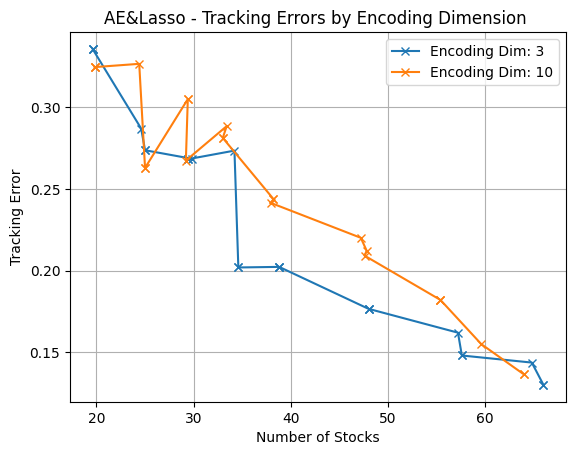

In [22]:
plot_AE_Lasso(daily_X,daily_y)

# Conclusions

We can observe that all models follow a similar trend, where the tracking error is lower the higher the number of stocks we can invest in, but we can still see that our models obtain decent results with a very low number of stocks (under 20) which range between 0.2 and 0.3%. The best results are seen from the Lasso - ElasticNet experiment, while the rest of the applied methods exhibit varying results but slightly worse than this one. This could be due to the way that Lasso performs feature selection. 

Since Lasso drops features based on their impact towards the target variable (NIFTY 100 Index Price) it might be better at removing features that are less useful in influencing the index price, while other feature selection methods, such as correlation, mutual information or autoencoders, don't include the output in their decision to assign weights or scored to features.

## Future Work

Future Work
For future work, we could explore other autoencoder architectures to enhance our feature selection process. Some examples of autoencoder architectures that might be considered include:

* **Variational Autoencoders (VAE)**: These are designed to learn a probabilistic representation of the input data, which can be useful for generating new data points similar to the original data.
* **Denoising Autoencoders (DAE)**: These are trained to reconstruct the input data from a corrupted version, helping in learning robust feature representations.
  
Additionally, we could explore other feature selection algorithms, such as:

* **Recursive Feature Elimination (RFE)**: This method recursively removes the least important features and builds the model on the remaining features. It uses the model’s accuracy to identify the optimal number of features.
* **Tree-based Feature Selection**: Algorithms like Random Forests and Gradient Boosting Trees can provide feature importances, which can be used to select features that contribute significantly to the target variable.
  
Exploring these additional methods and architectures could lead to improved feature selection, thereby enhancing the performance of our models in the partial replication of stock indices.

##### 